In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../utils/")
# from res_processing_utils import get_ave_metric, running_mean
from res_processing_utils import *
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from plot_utils import save_csv

In [2]:
top_directory = "/dfs/scratch0/zjian/floating_halp/exp_res/logreg_hyper_sweep_2018_nov_17/"
pattern = "opt_sgd_momentum_0.0_lr_0.01_l2_reg_0.0005_"
train_loss = get_ave_metric(pattern, top_directory, seed_list=[1,2,3], metric="train_loss")
test_loss = get_ave_metric(pattern, top_directory, seed_list=[1,2,3], metric="test_loss")
test_acc = get_ave_metric(pattern, top_directory, seed_list=[1,2,3], metric="test_acc")
grad_norm = get_ave_metric(pattern, top_directory, seed_list=[1,2,3], metric="grad_norm")

In [3]:
train_loss.shape, test_loss.shape, test_acc.shape, grad_norm.shape

((60000,), (100,), (100,), (60000,))

In [4]:
train_loss[-1], test_loss[-1], test_acc[-1], grad_norm[-1]

(0.32927932268381116,
 0.3103491183593869,
 0.9214333333333333,
 0.3436193296670582)

In [5]:
def get_config_with_best_test_acc(top_directory, pattern_list, seed_list=[1, 2, 3], cut_off_epoch=100, total_epoch=100):
    best_test_acc = 0.0
    best_config = ""
    best_acc_epoch_id = 0
    for pattern in pattern_list:
        ave_acc = None
        for seed in seed_list:
            dir = pattern + "seed_" + str(seed)
            if not os.path.exists(top_directory + "/" + dir + "/run.log"):
                print(top_directory + "/" + dir + "/run.log missing!" )
                continue
            acc = get_test_acc(top_directory + "/" + dir + "/run.log")
            if len(acc) == 0:
                print(top_directory + "/" + dir + "/run.log has 0 test accuracy record" )
                continue
            if ave_acc is None:
                ave_acc = np.array(acc)
            else:
                ave_acc += np.array(acc)
        ave_acc /= len(seed_list)
        assert cut_off_epoch <= total_epoch
        ave_acc = ave_acc[:cut_off_epoch]
        if np.max(ave_acc) > best_test_acc:
            best_test_acc = np.max(ave_acc)
            best_test_acc_full = ave_acc
            best_config = pattern
            best_acc_epoch_id = np.argmax(ave_acc)
    print("best test acc and config ", best_test_acc, best_acc_epoch_id, best_config)
    return (best_test_acc_full, best_acc_epoch_id, best_test_acc, best_config)

In [6]:
def get_config_with_best_train_loss(top_directory, pattern_list, seed_list=[1, 2, 3], win_width=1000, cut_off_epoch=100, total_epoch=100):
        best_train_loss = np.finfo(dtype=np.float64).max 
        best_config = ""
        best_loss_epoch_id = 0
        for pattern in pattern_list:
                ave_loss = None
                try:
                    for seed in seed_list:
                            #print(pattern, seed)
                            dir = pattern + "seed_" + str(seed)
                            if not os.path.exists(top_directory + "/" + dir + "/run.log"):
                                    print(top_directory + "/" + dir + "/run.log missing!" )
                                    continue
                            loss = get_train_loss(top_directory + "/" + dir + "/run.log")
                            if len(loss) == 0:
                                    print(top_directory + "/" + dir + "/run.log has 0 train loss record" )
                                    continue
                            if ave_loss is None:
                                     ave_loss = np.array(loss)
                            else:
                                     ave_loss += np.array(loss)
                    ave_loss /= len(seed_list)
                    assert cut_off_epoch <= total_epoch
                    iter_thresh = ave_loss.size * cut_off_epoch // total_epoch
                    ave_loss = ave_loss[:iter_thresh]
                    ave_loss = running_mean(ave_loss, N=win_width)
                    #print(pattern, np.min(ave_loss))
                    if np.min(ave_loss) <  best_train_loss:
                            best_train_loss = np.min(ave_loss)
                            best_train_loss_full = ave_loss
                            best_config = pattern
                            best_loss_epoch_id = np.argmin(ave_loss)
                except:
                        continue
        print("best train loss and config ", best_train_loss, best_loss_epoch_id, best_config)
        return (best_train_loss_full, best_loss_epoch_id, best_train_loss, best_config)

In [17]:
def plot_test_acc(label_list, test_acc_list, x=None, ylim=[None, None]):
    plt.figure()
    data_list = []
    for test_acc, label in zip(test_acc_list, label_list):
        data_list.append((label, np.arange(test_acc.size) + 1, test_acc))
        if x is not None:
            plt.plot(x, test_acc, label=label)
        else:
            plt.plot(test_acc, label=label)
    plt.legend(loc="lower right")
    plt.ylim([0.6, 0.65])
    # plt.xlim([None, 60])
    plt.xlabel("Epoch")
    plt.ylabel("Test accuracy")
    plt.title("CIFAR10 (LeNet)")
    plt.grid()
    plt.show()
#     save_csv(data_list, file_name="./workspace/lenet_test_acc_all.csv")

    plt.figure()
    data_list = []
    for test_acc, label in zip(test_acc_list, label_list):
        data_list.append((label, np.arange(test_acc.size) + 1, np.maximum.accumulate(test_acc)))
        if x is not None:
            plt.plot(x, np.maximum.accumulate(test_acc), label=label)
        else:
            plt.plot(np.maximum.accumulate(test_acc), label=label)
    plt.legend(loc="lower right")
    plt.ylim(ylim)
    # plt.xlim([None, 60])
    plt.xlabel("Epoch")
    plt.ylabel("Test accuracy")
    plt.title("CIFAR10 (LeNet)")
    plt.grid()
    plt.show()
#     save_csv(data_list, file_name="./workspace/lenet_test_acc_all.csv")


def plot_train_loss(label_list, train_loss_list, ylim=[None, None]):
    plt.figure()
    data_list = []
    for train_loss, label in zip(train_loss_list, label_list):
        data_list.append((label, np.arange(train_loss.size) + 1, train_loss))
        plt.plot(train_loss, label=label)
    plt.legend()
    plt.ylim(ylim)
    plt.xlabel("Iterations")
    plt.ylabel("Training loss")
    plt.title("CIFAR10 (LeNet)")
    plt.grid()
    plt.show()
#     save_csv(data_list, file_name="./workspace/lenet_train_loss_all.csv")

## overall report

In [27]:
def plot_best_config_fixed_epochs(cut_off_epoch=100, total_epoch=100, win_width=1000, top_directory = "/dfs/scratch0/zjian/floating_halp/exp_res/lenet_hyper_sweep_2018_nov_17/"):
    pattern_list_array = [ ["_bc-svrg"], ["_lp-svrg"], ["_svrg"], ["_bc-sgd"], ["_lp-sgd"], ["_sgd"]]
    plot_label_list = ["halp", "fp16 lp-svrg", "fp32 svrg", "fp16 bc-sgd", "fp16 lp-sgd", "fp32 sgd"]
#     top_directory = "/dfs/scratch0/zjian/floating_halp/exp_res/lenet_hyper_sweep_2018_nov_17/"
    all_directories = get_immediate_subdirectories(top_directory)
    all_directories = get_subdirectories_patterns_without_seed(all_directories)

    best_train_loss_list = []
    best_test_acc_list = []
    best_train_loss_config_list = []
    best_test_acc_config_list = []
    for pattern_list in pattern_list_array:
        print("\n")
        print(pattern_list)
        dir_list = filter_directory_names(all_directories, pattern_list)
        res = get_config_with_best_test_acc(top_directory, dir_list, cut_off_epoch=cut_off_epoch, total_epoch=total_epoch)
        best_test_acc_list.append(res[0])
        best_test_acc_config_list.append(res[1])
        res = get_config_with_best_train_loss(top_directory, dir_list, win_width=win_width, cut_off_epoch=cut_off_epoch, total_epoch=total_epoch)
        best_train_loss_list.append(res[0])
        best_train_loss_config_list.append(res[1])

    plot_test_acc(pattern_list_array, best_test_acc_list)
    plot_train_loss(pattern_list_array, best_train_loss_list)
    return best_test_acc_list, best_train_loss_list, plot_label_list



['_bc-svrg']
best test acc and config  0.9267666666666666 25 opt_bc-svrg_momentum_0.9_lr_0.05_l2_reg_1e-05_
best train loss and config  0.22660304872279086 58706 opt_bc-svrg_momentum_0.9_lr_0.05_l2_reg_1e-05_


['_lp-svrg']
best test acc and config  0.9238333333333334 3 opt_lp-svrg_momentum_0.9_lr_0.05_l2_reg_1e-05_
best train loss and config  0.2403301821039222 58106 opt_lp-svrg_momentum_0.0_lr_0.5_l2_reg_1e-05_


['_svrg']
best test acc and config  0.9268 62 opt_svrg_momentum_0.9_lr_0.05_l2_reg_1e-05_
best train loss and config  0.22655917075430443 58706 opt_svrg_momentum_0.9_lr_0.05_l2_reg_1e-05_


['_bc-sgd']
best test acc and config  0.9264333333333333 76 opt_bc-sgd_momentum_0.9_lr_0.01_l2_reg_1e-05_
best train loss and config  0.24218330606505334 58706 opt_bc-sgd_momentum_0.0_lr_0.5_l2_reg_1e-05_


['_lp-sgd']
best test acc and config  0.9249 87 opt_lp-sgd_momentum_0.9_lr_0.01_l2_reg_1e-05_
best train loss and config  0.24265284339095888 58706 opt_lp-sgd_momentum_0.0_lr_0.5_l2_

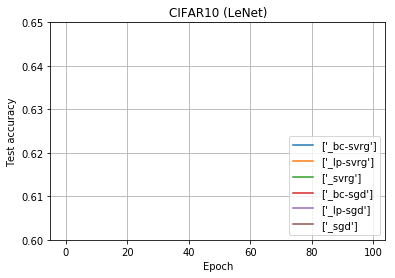

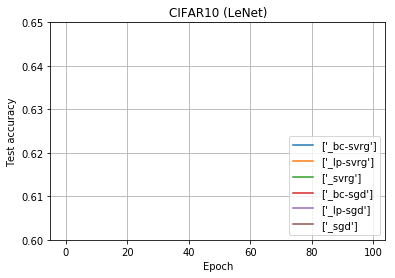

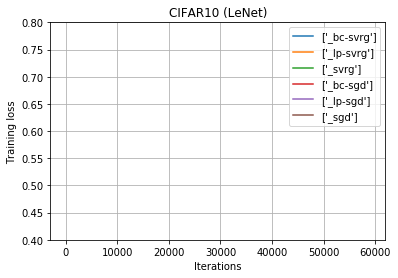

In [28]:
best_test_acc_list, best_train_loss_list, plot_label_list = \
    plot_best_config_fixed_epochs(cut_off_epoch=100, 
                                 total_epoch=100, 
                                 win_width=1000,
                                 top_directory = "/dfs/scratch0/zjian/floating_halp/exp_res/logreg_hyper_sweep_2018_nov_17/")

In [29]:
import pandas as pd
def save_csv(data_list, file_name="./test/test.xlsx", ave_x=False):
    '''
    data is a list of tuple (label, x_pt, y_pt), it is plotted using color named as label in the color_dict.
    x_pt is a 1d list, y_pt is list of list, each inner list is from a random seed.
    '''
    df_list = []
    for i in range(len(data_list) ):
        label = data_list[i][0]
        x = data_list[i][1]
        y = data_list[i][2]
        df_list.append(pd.DataFrame(np.reshape(x, [x.size, 1] ), columns = [label] ) )
        df_list.append(pd.DataFrame(np.reshape(y, [y.size, 1] ), columns = [label] ) )
    pd.concat(df_list, axis=1).to_excel(file_name)

In [30]:
data_list = [(name, np.arange(y.size) + 1, np.maximum.accumulate(y)) \
             for name, y in zip(plot_label_list, best_test_acc_list)]
save_csv(data_list, 
         file_name="./data/logreg_test_acc_all.xlsx")
data_list = [(name, np.arange(y.size) + 1, y) \
             for name, y in zip(plot_label_list, best_train_loss_list)]
save_csv(data_list, 
         file_name="./data/logreg_train_loss_all.xlsx")

In [22]:
def plot_best_config_multiple_epochs(ckpt_epochs, total_epoch=100, win_width=1000, top_directory = "/dfs/scratch0/zjian/floating_halp/exp_res/lenet_hyper_sweep_2018_nov_17/"):
    pattern_list_array = [ ["_bc-svrg"], ["_lp-svrg"], ["_svrg"], ["_bc-sgd"], ["_lp-sgd"], ["_sgd"]]
    plot_label_list = ["halp", "fp16 lp-svrg", "fp32 svrg", "fp16 bc-sgd", "fp16 lp-sgd", "fp32 sgd"]
#     pattern_list_array = [ ["_bc-svrg"], ["_lp-svrg"]]
#     plot_label_list = ["halp", "fp16 lp-svrg"]
#     top_directory = "/dfs/scratch0/zjian/floating_halp/exp_res/lenet_hyper_sweep_2018_nov_17/"
    all_directories = get_immediate_subdirectories(top_directory)
    all_directories = get_subdirectories_patterns_without_seed(all_directories)

    best_train_loss_list = []
    best_test_acc_list = []
    best_train_loss_config_list = []
    best_test_acc_config_list = []
    for pattern_list in pattern_list_array:
        best_train_loss_list_single_type = []
        best_test_acc_list_single_type = []
        best_train_loss_config_list_single_type = []
        best_test_acc_config_list_single_type = []
        for ckpt_epoch in ckpt_epochs:
            print("\n")
            print(pattern_list, ckpt_epoch)
            dir_list = filter_directory_names(all_directories, pattern_list)
            res = get_config_with_best_test_acc(top_directory, dir_list, cut_off_epoch=ckpt_epoch, total_epoch=total_epoch)
            best_test_acc_list_single_type.append(res[2])
            best_test_acc_config_list_single_type.append(res[1])
            res = get_config_with_best_train_loss(top_directory, dir_list, win_width=win_width, cut_off_epoch=ckpt_epoch, total_epoch=total_epoch)
            best_train_loss_list_single_type.append(res[2])
            best_train_loss_config_list_single_type.append(res[1])
        best_test_acc_list.append(np.array(best_test_acc_list_single_type))
        best_train_loss_list.append(np.array(best_train_loss_list_single_type))

    plot_test_acc(pattern_list_array, best_test_acc_list, x=ckpt_epochs)
    plot_train_loss(pattern_list_array, best_train_loss_list)
    return ckpt_epochs, best_train_loss_list, best_test_acc_list 



['_bc-svrg'] 3
best test acc and config  0.9219333333333332 2 opt_bc-svrg_momentum_0.9_lr_0.05_l2_reg_1e-05_
best train loss and config  0.2817806719072933 796 opt_bc-svrg_momentum_0.9_lr_0.05_l2_reg_1e-05_


['_bc-svrg'] 5
best test acc and config  0.9242333333333334 3 opt_bc-svrg_momentum_0.9_lr_0.05_l2_reg_1e-05_
best train loss and config  0.26047026570456283 1744 opt_bc-svrg_momentum_0.9_lr_0.1_l2_reg_1e-05_


['_bc-svrg'] 10
best test acc and config  0.9255666666666666 9 opt_bc-svrg_momentum_0.9_lr_0.05_l2_reg_1e-05_
best train loss and config  0.24924836906556858 4706 opt_bc-svrg_momentum_0.9_lr_0.05_l2_reg_1e-05_


['_bc-svrg'] 15
best test acc and config  0.9259666666666666 14 opt_bc-svrg_momentum_0.9_lr_0.05_l2_reg_1e-05_
best train loss and config  0.24317532787012533 7706 opt_bc-svrg_momentum_0.9_lr_0.05_l2_reg_1e-05_


['_bc-svrg'] 20
best test acc and config  0.9262 18 opt_bc-svrg_momentum_0.9_lr_0.05_l2_reg_1e-05_
best train loss and config  0.23949795970737206 10706 o

best test acc and config  0.9153333333333333 2 opt_sgd_momentum_0.9_lr_0.01_l2_reg_1e-05_
best train loss and config  0.29808932806624183 796 opt_sgd_momentum_0.0_lr_0.5_l2_reg_1e-05_


['_sgd'] 5
best test acc and config  0.9181333333333334 4 opt_sgd_momentum_0.9_lr_0.01_l2_reg_5e-05_
best train loss and config  0.2813305679236898 1767 opt_sgd_momentum_0.0_lr_0.5_l2_reg_1e-05_


['_sgd'] 10
best test acc and config  0.9218333333333333 9 opt_sgd_momentum_0.9_lr_0.01_l2_reg_0.0001_
best train loss and config  0.26625361995907976 4706 opt_sgd_momentum_0.0_lr_0.5_l2_reg_1e-05_


['_sgd'] 15
best test acc and config  0.9232999999999999 14 opt_sgd_momentum_0.9_lr_0.01_l2_reg_5e-05_
best train loss and config  0.25977194727614233 7706 opt_sgd_momentum_0.0_lr_0.5_l2_reg_1e-05_


['_sgd'] 20
best test acc and config  0.9232999999999999 14 opt_sgd_momentum_0.9_lr_0.01_l2_reg_5e-05_
best train loss and config  0.2558663611963248 10706 opt_sgd_momentum_0.0_lr_0.5_l2_reg_1e-05_


['_sgd'] 30
best 

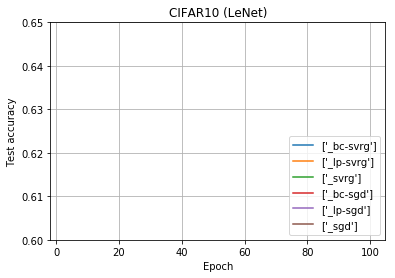

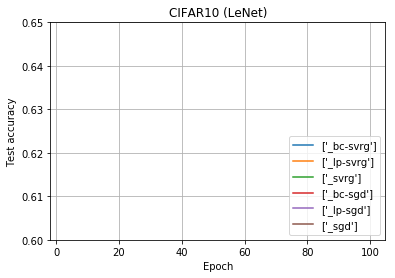

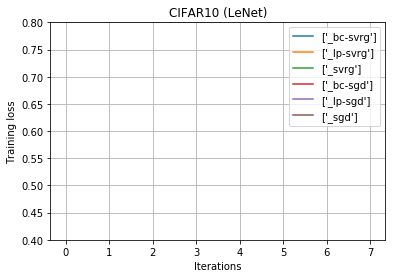

In [23]:
# ckpt_epochs = np.arange(10, 101, 30)
ckpt_epochs = np.array([3, 5, 10, 15, 20, 30, 50, 100])
_, best_train_loss_list, best_test_acc_list = plot_best_config_multiple_epochs(ckpt_epochs, 
                                                                               total_epoch=100, 
                                                                               win_width=1000, 
                                                                               top_directory = "/dfs/scratch0/zjian/floating_halp/exp_res/logreg_hyper_sweep_2018_nov_17/")


In [26]:
data_list = [(name, ckpt_epochs, np.maximum.accumulate(y)) \
             for name, y in zip(plot_label_list, best_test_acc_list)]
save_csv(data_list, 
         file_name="./data/logreg_test_acc_all_temporal.xlsx")
data_list = [(name, ckpt_epochs, y) \
             for name, y in zip(plot_label_list, best_train_loss_list)]
save_csv(data_list, 
         file_name="./data/logreg_train_loss_all.xlsx")